In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

## 설명 가능한 네트워크 생성

In [2]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes = 2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True), # 기존의 데이터를 연산의 결괏값으로 대체하는 것을 의미.
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(256, 512, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias = False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x) # 소프트맥스 함수에 log를 취한 값. (일반 소프트맥스보다 기울기 소멸에 덜 취약함)


        

## 모델 객체화

In [3]:
model = XAI() # model 이라는 이름의 객체를 생성
model.to(device) # model을 장치(CPU or GPU)에 할당
model.eval() # 테스트 데이터에 대한 모델 평가 용도로 사용

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

## 특성 맵을 확인하기 위한 클래스 정의

In [4]:
class LayerActivations:
    features = []
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
        # PyTorch에서는 매 계층마다 print문을 사용하지 않더라도 'hook' 기능을 사용하여 각 계층의 활성화 함수 및 기울기 값을 확인할 수 있다.
        # register_forward_hook의 목적은 순전파 과정중에 각 네트워크 모듈의 입력 및 출력을 가져오는 것.
        
    def hook_fn(self, module, input, output):
        self.features = output.detach().cpu().numpy()
        
    def remove(self):
        self.hook.remove()

In [ ]:
import torch
x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x + y
print(z)
o = w.matmul(z)
print(o)

o.backward()
print(x.grad, y.grad, z.grad, w.grad, o.grad)

* 위의 코드에서 o와 z는 특정한 값으로 정의되지 않은 중간 변수(계산 결과에 따라 값이 달라질 수 있는 변수)이다.
* 파이토치는 이러한 변수에 대해서는 기울기 값을 저장하지 않는다.
* 하지만 이러한 중간 변수에 대해 z.register_hook(hook_fn)을 사용하면 기울기 값을 알 수 있다.

## 이미지 호출

torch.Size([1, 3, 100, 100])


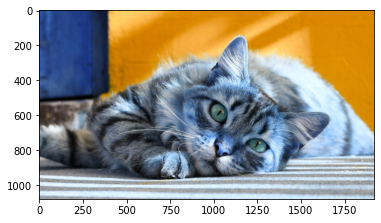

In [5]:
img = cv2.imread('../input/cat-single-img/cat.jpeg')
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_LINEAR) # 보간법, 픽셀 추정할 때 사용하는 기법
img = ToTensor()(img).unsqueeze(0) # unsqueeze() -> 1차원 데이터를 생성하는 함수. e.g. unsqueeze(0) : [3, 10, 64] -> [1, 3, ]
#pytorch (and most other DL toolboxes) expects a batch of images as an input. Thus you need to call it by
#Inserting a singleton "batch" dimension to your input data.
img = img.to(device)
print(img.shape)


## 특성 맵 확인

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


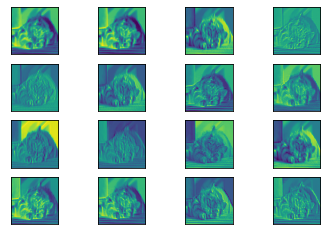

<Figure size 864x576 with 0 Axes>

In [6]:
result = LayerActivations(model.features, 0) # [(0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)] 특성 맵 확인 
model(img)
activations = result.features 

fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize = (12, 8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row * 10 + column])
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


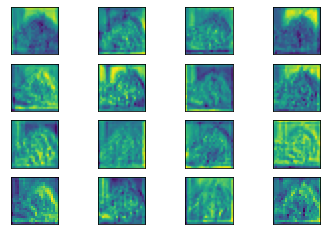

<Figure size 864x576 with 0 Axes>

In [7]:
# 20번째 계층에 대한 특성 맵 확인
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize = (12, 8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row * 10 + column])
plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


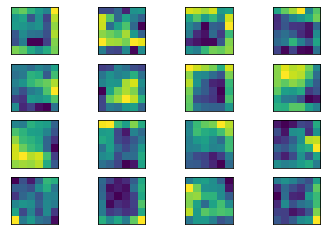

<Figure size 864x576 with 0 Axes>

In [8]:
# 40번째 계층에 대한 특성 맵

result = LayerActivations(model.features, 40)

model(img)
activations = result.features 

fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize = (12, 8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row * 10 + column])
plt.show()